# load module to use pipeline process.

In [1]:

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from skimage.feature import hog
#from scipy.ndimage.measurements import label
from scipy.ndimage import measurements

from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import time
import pickle
import collections

from utils_vehicles import showImageList

import seaborn as sns

from multiprocessing import Pool
% matplotlib inline

In [2]:
print(" load X / y train test data ....")
X_train =    np.load("X_train.npy"  )
X_test =    np.load("X_test.npy"  )
y_train =    np.load("y_train.npy"   )
y_test =    np.load("y_test.npy"   )

 load X / y train test data ....


In [3]:
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [4]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    img = image.copy()
    img = img.astype(np.float32) / 255.
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


## Data preparation process for multiprocess technique

In [5]:

# parameters setting 
cars = glob.glob('./sample_data/vehicles/**/*.png')
notcars = glob.glob('./sample_data/non-vehicles/**/*.png')


### Model Parameters settting for training and image processing

In [6]:

hist_range=(0,256)
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 128    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

y_start_stop = [375, 640]

In [7]:

pool = Pool(8)

print(" building feature & models for sliding window")

print("-" * 30)
print(color_space,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,hist_range)

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

#X_scaler = StandardScaler().fit(X)
#X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
# Apply the scaler to X
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


 building feature & models for sliding window
------------------------------
YCrCb 9 8 2 ALL (16, 16) 128 (0, 256)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6444
23.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/Users/donchan/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-2:
  File "/Users/donchan/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/donchan/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/Users/donchan/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
Process ForkPoolWorker-3:
  File "/Users/donchan/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
AttributeError: Can't get attribute 'process_image' on <module '__main__'>
  File "/Users/donchan/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-4:
Trace

## preparation for multi processes to make speedup building features ...

In [8]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def sliding_window_sampler(img, offset=32, block_size=64):
    data_img = []
    shape = img.shape

    for xo in range(((shape[0] - block_size) // offset)+1):
        for yo in range(((shape[1] - block_size) // offset)+1):  
            mini_img = img[xo*offset:xo*offset+block_size, yo*offset:yo*offset+block_size, :]
            data_img.append(mini_img)
    return np.array(data_img)

In [9]:
def process_image(img):
    if img.shape != (64, 64, 3):
        img = cv2.resize(img, (64, 64))
    
    
    features = single_img_features(img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)    
    
    test_features = X_scaler.transform( features.reshape(1,-1) )
    

    return test_features.ravel()

In [10]:
#search_spaces = [
#    (380, 500, 0, 1280, 64, 8),
#    (380, 600, 0, 1280, 96, 24),
#    (400, 700, 0, 1280, 128, 32),
#    (400, 700, 0, 1280, 256, 64)
#    ]
search_spaces = [
    (350, 650, 0, 1280, 64, 10),
    (350, 650, 0, 1280, 96, 32),
    (400, 700, 0, 1280, 128, 32)
    ]



In [11]:
def binary_mask_to_boxes(img, heatmap):
    img = img.copy()
    clusters = measurements.label(heatmap)
    for label in range(1, clusters[1]+1):
        where = np.where(clusters[0] == label)
        xmin, xmax, ymin, ymax = where[1].min(), where[1].max(), where[0].min(), where[0].max()
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 255), 3)
    return img


# load test road data

In [12]:

frame_range = range(500,1060)
print("test image sizes", len(frame_range))

project_images = [ os.path.join("./project", "frame" + str(r) + ".jpg") for r in frame_range ]
imread_op = lambda x:mpimg.imread(x)
p_images = list(map( imread_op, project_images )) 

test image sizes 560


In [13]:
filenames = [f.split('/')[-1] for f in project_images ]

## Pipeline process

In [96]:

last_heatmap = None
alpha = 0.2
def image_pipeline(image):
    
    global last_heatmap

    heatmap = np.zeros(image.shape[:2])
    input_img = image.copy()
    
    for top, bottom, left, right, block_size, offset in search_spaces:
        img = input_img[top:bottom, left:right]
        shape = img.shape
        #print(img.shape)

        data_img = sliding_window_sampler(img, offset, block_size)

        x_features = np.array( pool.map( process_image, data_img ) ) 
        #print(x_features.shape)    

        p= svc.predict(x_features)
        #print(" number of Car objects ",  len(p[p==1]) )
        

        i = 0 
        for xo in range(((shape[0] - block_size) // offset)+1):
            for yo in range(((shape[1] - block_size) // offset)+1):    
                heatmap[(xo*offset)+top:(xo*offset+block_size)+top, (yo*offset)+left:(yo*offset+block_size)+left] += p[i]
                i += 1
                
    if last_heatmap is not None:
        heatmap = (heatmap * alpha) + (last_heatmap * (1 - alpha))
    last_heatmap = heatmap

    heat = apply_threshold(heatmap,1)
    draw_image = binary_mask_to_boxes( input_img, heat )
    return draw_image


In [101]:
draw_image  =  image_pipeline(p_images[10])

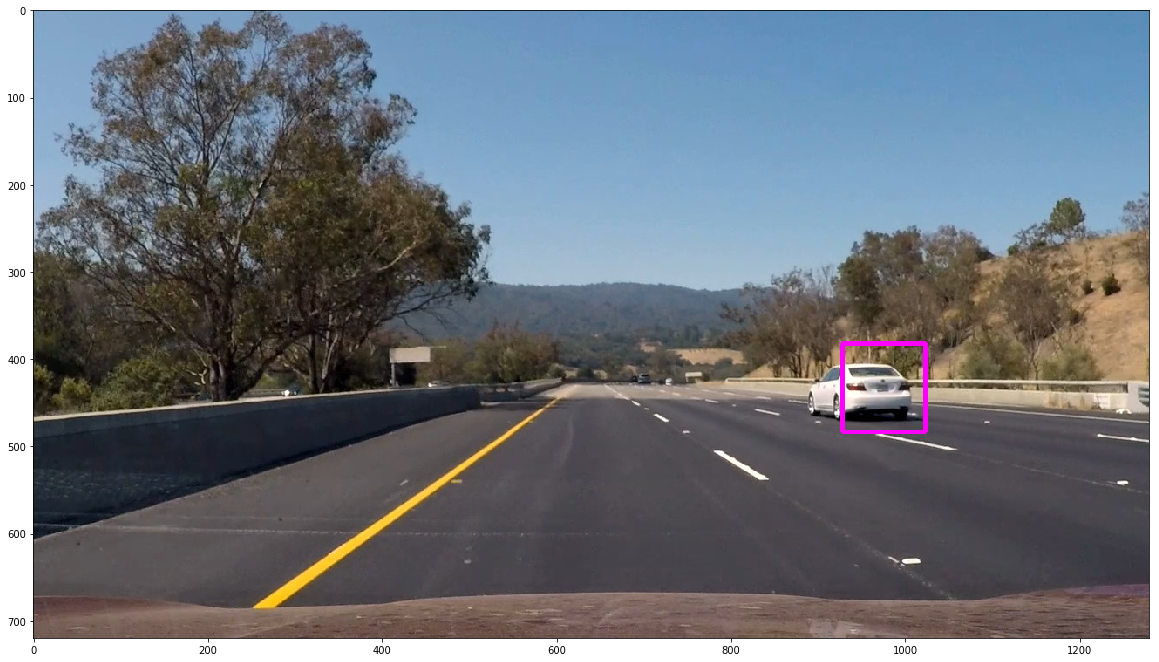

In [102]:

plt.figure( figsize=(20,12))
plt.imshow(draw_image)

In [17]:
class VDetector(object):
    
    def __init__(self):
        
        self.last_heatmap = None

        self.alpha = 0.2
    
    def image_pipeline(self,image):


        heatmap = np.zeros(image.shape[:2])
        input_img = image.copy()

        for top, bottom, left, right, block_size, offset in search_spaces:
            img = input_img[top:bottom, left:right]
            shape = img.shape
            #print(img.shape)

            data_img = sliding_window_sampler(img, offset, block_size)

            x_features = np.array( pool.map( process_image, data_img ) ) 
            #print(x_features.shape)    

            p= svc.predict(x_features)
            #print(" number of Car objects ",  len(p[p==1]) )


            i = 0 
            for xo in range(((shape[0] - block_size) // offset)+1):
                for yo in range(((shape[1] - block_size) // offset)+1):    
                    heatmap[(xo*offset)+top:(xo*offset+block_size)+top, (yo*offset)+left:(yo*offset+block_size)+left] += p[i]
                    i += 1

        if self.last_heatmap is not None:
            heatmap = (heatmap * self.alpha) + (self.last_heatmap * (1 - self.alpha))
        self.last_heatmap = heatmap

        heat = apply_threshold(self.last_heatmap,1)
        draw_image = binary_mask_to_boxes( input_img, heat )
        return draw_image
    

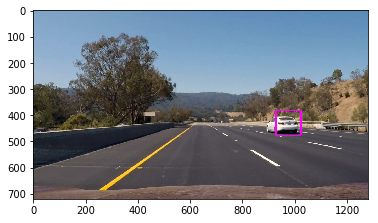

In [18]:
vd = VDetector()
res = vd.image_pipeline(  p_images[1] )
plt.imshow(res)

In [15]:
## import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
#vd = VDetector()
video_output = 'output_images/test_video_pool.mp4'
clip1 = VideoFileClip('test_video.mp4')
video_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_pool.mp4
[MoviePy] Writing video output_images/test_video_pool.mp4


 97%|█████████▋| 38/39 [02:27<00:03,  3.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_pool.mp4 

CPU times: user 10.3 s, sys: 7.52 s, total: 17.8 s
Wall time: 2min 28s


In [19]:
vd = VDetector()
video_output = 'output_images/project_video_pool2.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(vd.image_pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_pool2.mp4
[MoviePy] Writing video output_images/project_video_pool2.mp4


  2%|▏         | 29/1261 [03:44<2:38:50,  7.74s/it]

KeyboardInterrupt: 